In [1]:
import os
import random
import pandas as pd
import shutil
from pydub import AudioSegment
from IPython.display import Audio

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

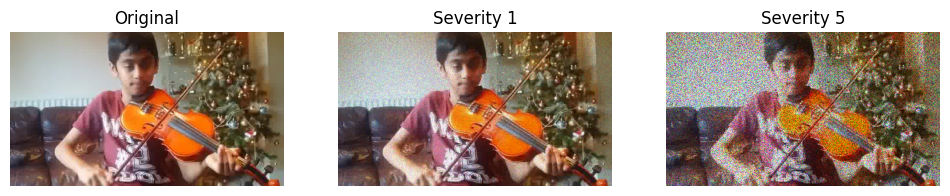

In [2]:
def gaussian_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]
    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255

# Load the image
image_path = "/mnt/user/saksham/AV_robust/AV-C-Robustness-Benchmark/data_recipe/analysis_helper/data/clean/playing_violin__fiddle.jpg"  # Change this to your image path
original = cv2.imread(image_path)  # Load using OpenCV
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply Gaussian noise at severity 1 and 5
image_severity_1 = gaussian_noise(original, severity=1).astype(np.uint8)
image_severity_5 = gaussian_noise(original, severity=5).astype(np.uint8)

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original)
axes[0].set_title("Original")
axes[1].imshow(image_severity_1)
axes[1].set_title("Severity 1")
axes[2].imshow(image_severity_5)
axes[2].set_title("Severity 5")

for ax in axes:
    ax.axis("off")

plt.show()

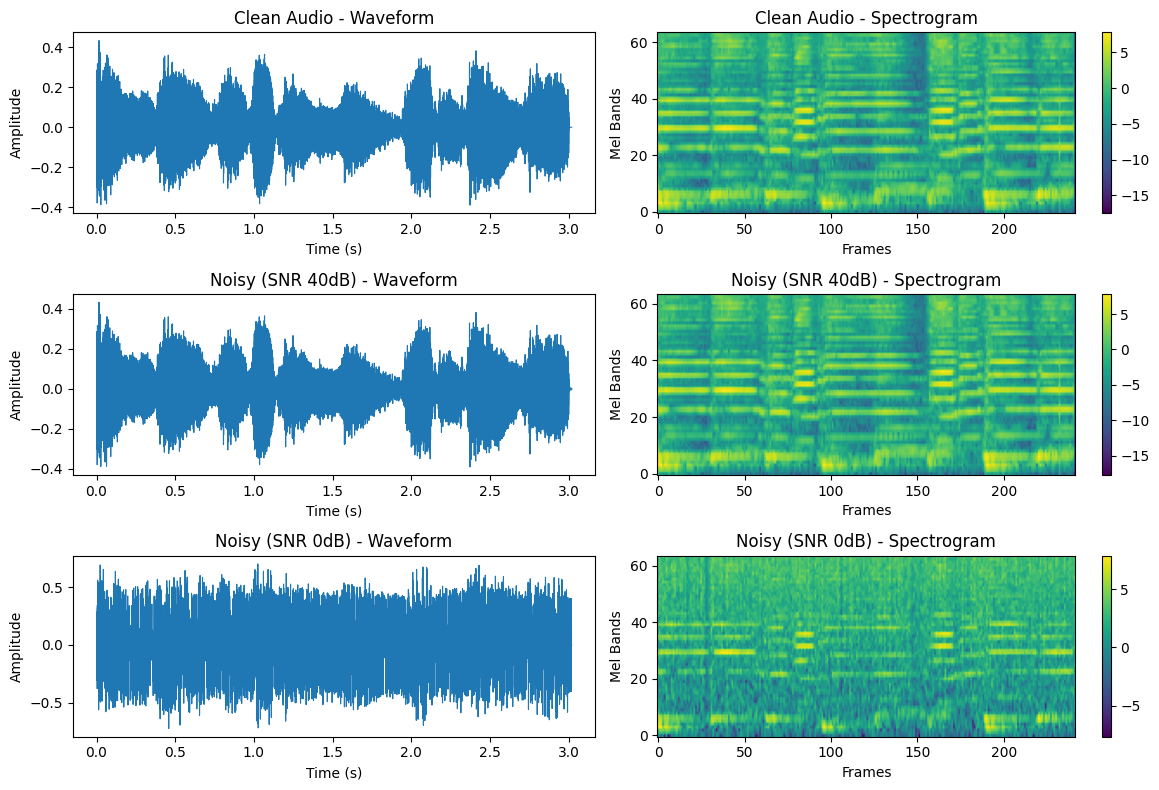

In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt

NOISE_SNRS = [40, 30, 20, 10, 0]  # SNR levels for different noise intensities

def add_gaussian_noise(waveform, intensity):
    """
    Adds Gaussian noise to a waveform using torchaudio.functional.add_noise.
    """
    snr_level = NOISE_SNRS[intensity - 1]
    impulse_prob = 0.05
    signal_power = torch.mean(waveform ** 2)
    random_mask = torch.rand_like(waveform)  # Random values in [0,1]
    salt_pepper = torch.where(
        random_mask < (impulse_prob / 2), -1.0,  # Set to -1 (salt)
        torch.where(random_mask > (1 - impulse_prob / 2), 1.0, 0.0)  # Set to 1 (pepper), else 0
    )
    noise_power = torch.mean(salt_pepper ** 2) + 1e-8  # Prevent division by zero
    snr_linear = 10 ** (snr_level / 10)  # Standard dB to linear conversion
    noise_scaling_factor = torch.sqrt(signal_power / (snr_linear * noise_power))
    salt_pepper = noise_scaling_factor * salt_pepper
    y_noisy = torch.clamp(waveform + salt_pepper, -1.0, 1.0)
    return y_noisy

def plot_waveform_and_spectrogram(waveform, sr, title, ax1, ax2):
    """
    Plots the waveform and spectrogram of an audio signal.
    """
    ax1.plot(torch.arange(waveform.shape[1]) / sr, waveform.numpy().squeeze(), linewidth=0.8)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")

    transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)
    mel_spec = transform(waveform)

    im = ax2.imshow(mel_spec.log2().numpy().squeeze(), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Spectrogram")
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Mel Bands")
    plt.colorbar(im, ax=ax2)

# Load audio file
audio_path = "/mnt/user/saksham/AV_robust/AV-C-Robustness-Benchmark/data_recipe/analysis_helper/data/clean/playing_violin__fiddle.wav"  # Change this to your actual audio file path
waveform, sr = torchaudio.load(audio_path)

# Generate noisy versions
waveform_noise_1 = add_gaussian_noise(waveform, 1)  # Least noise (SNR = 40dB)
waveform_noise_5 = add_gaussian_noise(waveform, 5)  # Most noise (SNR = 0dB)

# Plot waveforms and spectrograms
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

plot_waveform_and_spectrogram(waveform, sr, "Clean Audio", axes[0, 0], axes[0, 1])
plot_waveform_and_spectrogram(waveform_noise_1, sr, "Noisy (SNR 40dB)", axes[1, 0], axes[1, 1])
plot_waveform_and_spectrogram(waveform_noise_5, sr, "Noisy (SNR 0dB)", axes[2, 0], axes[2, 1])

plt.tight_layout()
plt.show()
